# Análise exploratória de dados

Após o tratamento dos dados, passamos para a etapa inicial de análise dos dados procurando por características importantes presentes nos dados e avaliando hipóteses criadas sobre as variáveis presentes. Nossa principal variável de interesse será a nota média de cada aluno, iniciaremos procurando entender como ela se relaciona com as demais variáveis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
df = pd.read_csv('data/MICRODADOS_ENEM_SP_2019.csv', encoding = 'latin1')

C:\Users\giova\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Análise de dados faltantes

Entre os campos que possuímos, iremos olhar se existem linhas faltando informação e procurar por padrões que possivelmente expliquem a ausência.

In [3]:
print('Colunas com NANs e a taxa de NANs:')
nan_tx = list(df.isna().mean())
for i, col in enumerate(df.columns):
    if nan_tx[i] > 0:
        print('\t' + col + ': ' + str(np.round(nan_tx[i]*100, 2)) + '%')

Colunas com NANs e a taxa de NANs:
	NO_MUNICIPIO_NASCIMENTO: 2.42%
	SG_UF_NASCIMENTO: 2.42%
	TP_ENSINO: 44.41%
	CO_ESCOLA: 73.05%
	NO_MUNICIPIO_ESC: 73.05%
	SG_UF_ESC: 73.05%
	TP_DEPENDENCIA_ADM_ESC: 73.05%
	TP_LOCALIZACAO_ESC: 73.05%
	TP_SIT_FUNC_ESC: 73.05%
	NU_NOTA_CN: 28.41%
	NU_NOTA_CH: 23.73%
	NU_NOTA_LC: 23.73%
	NU_NOTA_MT: 28.41%
	TP_STATUS_REDACAO: 23.73%
	NU_NOTA_COMP1: 23.73%
	NU_NOTA_COMP2: 23.73%
	NU_NOTA_COMP3: 23.73%
	NU_NOTA_COMP4: 23.73%
	NU_NOTA_COMP5: 23.73%
	NU_NOTA_REDACAO: 23.73%
	NO_MUNICIPIO_ESC_LON: 73.05%
	NO_MUNICIPIO_ESC_LAT: 73.05%
	NO_MUNICIPIO_NASCIMENTO_LON: 2.42%
	NO_MUNICIPIO_NASCIMENTO_LAT: 2.42%


Cerca de 74% dos participantes não responderam informações sobre a escola em que estudam, isso é uma taxa bastante alta de informações que seriam úteis.

Além disso, a nota das provas não está presente para cerca de 24% dos participantes, informação que seria útil para realizar o treinamento de modelos. Vamos verificar se os alunos que estão com os campos sem notas foram alunos que faltaram no dia de aplicação da prova.

In [4]:
for prova in ['CN', 'MT', 'LC','CH']:
    missing_and_abscence = df[(df['NU_NOTA_'+prova].isna()) & (df['TP_PRESENCA_'+prova] == 0)].shape[0]
    missing = df[(df['NU_NOTA_'+prova].isna())].shape[0]
    print(f'Prova: {prova}')
    print(f'Notas ausentes e alunos que faltaram na aplicação : {100*missing_and_abscence/df.shape[0]:.2f}%')
    print(f'Notas ausentes: {100*missing/df.shape[0]:.2f}%')

Prova: CN
Notas ausentes e alunos que faltaram na aplicação : 28.37%
Notas ausentes: 28.41%
Prova: MT
Notas ausentes e alunos que faltaram na aplicação : 28.37%
Notas ausentes: 28.41%
Prova: LC
Notas ausentes e alunos que faltaram na aplicação : 23.64%
Notas ausentes: 23.73%
Prova: CH
Notas ausentes e alunos que faltaram na aplicação : 23.64%
Notas ausentes: 23.73%


Os campos ausentes na nota dos alunos representam alunos que não estavam presentes no dia da aplicação da prova, __28,37% dos inscritos faltaram no dia das provas de ciências humanas, linguagens e redação e 23,64% faltaram no dia das provas de ciências exatas e matemática__. Podemos procurar se há alguma distribuição entre os participantes que faltaram pelo menos um dia.

Porcentagem de participantes que faltaram em alguma prova: 28.58%
Idade média dos alunos presentes: 19.98
Idade média dos alunos ausentes: 23.22
Proporção de participantes presentes do sexo feminino: 58.50%
Proporção de participantes ausentes do sexo feminino: 60.27%


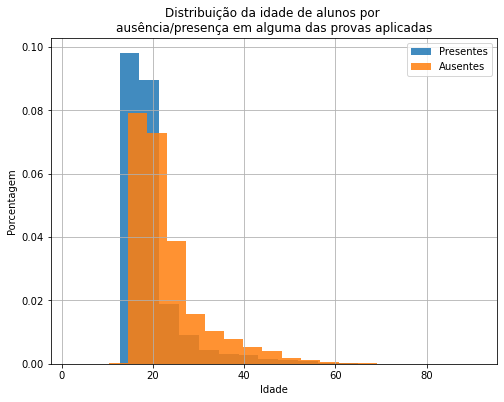

In [5]:
df['AUSENTE_PROVA'] = 1 - (df['TP_PRESENCA_CN'] &  df['TP_PRESENCA_LC'] &  df['TP_PRESENCA_CH'] &  df['TP_PRESENCA_MT'])

print(f'Porcentagem de participantes que faltaram em alguma prova: {df.AUSENTE_PROVA.mean()*100:.2f}%')
print(f'Idade média dos alunos presentes: {df[df.AUSENTE_PROVA == 0].NU_IDADE.mean():.2f}')
print(f'Idade média dos alunos ausentes: {df[df.AUSENTE_PROVA == 1].NU_IDADE.mean():.2f}')
abscence_female = df[((df.AUSENTE_PROVA == 0) & (df.TP_SEXO == 'F'))].shape[0]/df[df.AUSENTE_PROVA == 0].shape[0]
presence_female = df[((df.AUSENTE_PROVA == 1) & (df.TP_SEXO == 'F'))].shape[0]/df[df.AUSENTE_PROVA == 1].shape[0]
print(f'Proporção de participantes presentes do sexo feminino: {abscence_female * 100:.2f}%')
print(f'Proporção de participantes ausentes do sexo feminino: {presence_female * 100:.2f}%')

fig = plt.figure(figsize = (8, 6))
plt.hist(df[df.AUSENTE_PROVA == 0].NU_IDADE, bins = 20, density= True, alpha = 0.85, label = 'Presentes')
plt.hist(df[df.AUSENTE_PROVA == 1].NU_IDADE, bins = 20, density= True, alpha = 0.85, label = 'Ausentes')
plt.title('Distribuição da idade de alunos por \nausência/presença em alguma das provas aplicadas')
plt.grid()
plt.xlabel('Idade')
plt.ylabel('Porcentagem')
plt.legend()
plt.show()

Verificamos que a __idade dos participantes que não estiveram presentes na prova é em média um pouco maior do que os que estiveram todos os dias__, além disso, há uma pequena diferença entre a distribuição de gênero, __com as mulheres sendo mais ausentes__.

Vamos verificar se existe uma relação da ausência com a renda dos participantes. Para isso utilizaremos a questão 6 sobre a situação socioeconômica do participante que divide em categorias de acordo com a renda:
- A : de R\\$0,00 até R\\$0,00.
- B : de R\\$0,00 até R\\$998,00.
- C : de R\\$998,00 até R\\$1497,00.
- D : de R\\$1497,00 até R\\$1996,00.
- E : de R\\$1996,00 até R\\$2495,00.
- F : de R\\$2495,00 até R\\$2994,00.
- G : de R\\$2994,00 até R\\$3992,00.
- H : de R\\$3992,00 até R\\$4990,00.
- I : de R\\$4990,00 até R\\$5988,00.
- J : de R\\$5988,00 até R\\$6986,00.
- K : de R\\$6986,00 até R\\$7984,00.
- L : de R\\$7984,00 até R\\$8982,00.
- M : de R\\$8982,00 até R\\$9980,00.
- N : de R\\$9980,00 até R\\$11976,00.
- O : de R\\$11976,00 até R\\$14970,00.
- P : de R\\$14970,00 até R\\$19960,00.
- Q : maior que R$19960,00.

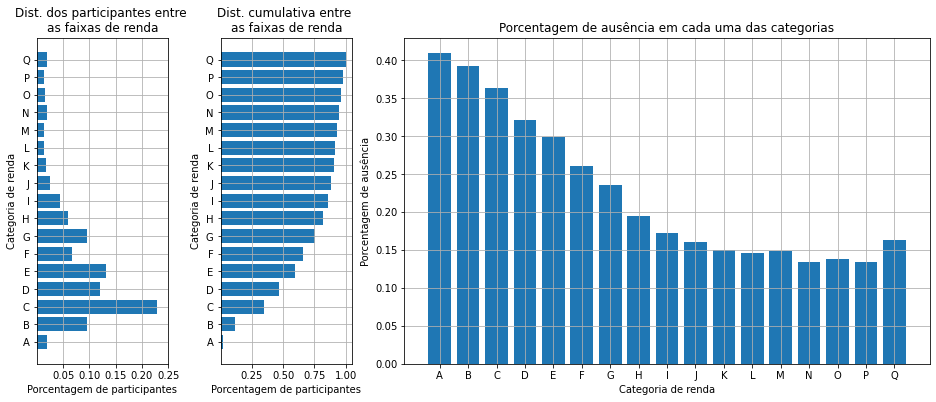

In [6]:
income_interval = {'A':[0, 0], 'B': [0, 998], 'C': [998, 1497], 'D':[1497, 1996], 'E':[1996, 2495],
                  'F':[2495, 2994], 'G': [2994, 3992], 'H':[3992, 4990], 'I':[4990, 5988], 'J':[5988, 6986],
                  'K':[6986, 7984], 'L':[7984, 8982], 'M':[8982, 9980], 'N':[9980, 11976], 'O':[11976, 14970], 
                   'P':[14970, 19960], 'Q':[19960, 100000]}
n_keys = len(list(income_interval.keys()))
fig = plt.figure(figsize = (16, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 4]) 
income_fraction = [[key, (df['Q006'] == key).mean()] for key in income_interval.keys()]
ax0 = plt.subplot(gs[0])
ax0.barh(y = list(range(n_keys)), width = [x[1] for x in income_fraction])
ax0.set_yticks(ticks = list(range(n_keys)))
ax0.set_yticklabels(labels = list(income_interval.keys()))
ax0.set_xticks(ticks = [0.05, 0.1, 0.15, 0.2, 0.25])
ax0.set_xlabel("Porcentagem de participantes")
ax0.set_ylabel("Categoria de renda")
ax0.set_title("Dist. dos participantes entre \nas faixas de renda")
ax0.grid()

income_abscence = [[key, df[(df['Q006'] == key) & (df.AUSENTE_PROVA == 1)].shape[0]/df[(df['Q006'] == key)].shape[0]] for key in income_interval.keys()]
ax1 = plt.subplot(gs[2])
ax1.bar(x = list(range(n_keys)), height = [x[1] for x in income_abscence])
ax1.set_xticks(ticks = list(range(n_keys)))
ax1.set_xticklabels(labels = list(income_interval.keys()))

ax1.set_title("Porcentagem de ausência em cada uma das categorias")
ax1.set_xlabel("Categoria de renda")
ax1.set_ylabel("Porcentagem de ausência")
ax1.grid()


income_keys = list(income_interval.keys())
income_keys += [" "]
income_fraction_cumulative = [[income_keys[i], (df['Q006'].isin(income_keys[:i+1])).mean()] for i in range(len(income_keys) - 1)]
ax2 = plt.subplot(gs[1])
ax2.barh(y = list(range(n_keys)), width = [x[1] for x in income_fraction_cumulative])
ax2.set_yticks(ticks = list(range(n_keys)))
ax2.set_yticklabels(labels = list(income_interval.keys()))
ax2.set_xticks(ticks = [0.25, 0.5, 0.75, 1])
ax2.set_xlabel("Porcentagem de participantes")
ax2.set_ylabel("Categoria de renda")
ax2.set_title("Dist. cumulativa entre \nas faixas de renda")
ax2.grid()


plt.show()

Podemos notar que __mais de 20% dos parcipantes possuem de R\\$998,00 até R\\$1497,00 de renda, e a maioria está nas faixas de renda menores, além disso, notamos que entre as faixas de renda A, B, e C a taxa de ausência nas provas é superior a 35%.__

Vamos agora verificar se existe alguma característica comum entre os alunos que não apresentaram os dados sobre a instituição de ensino.

Porcentagem com algum dado da instituição de ensino ausente: 74.32%


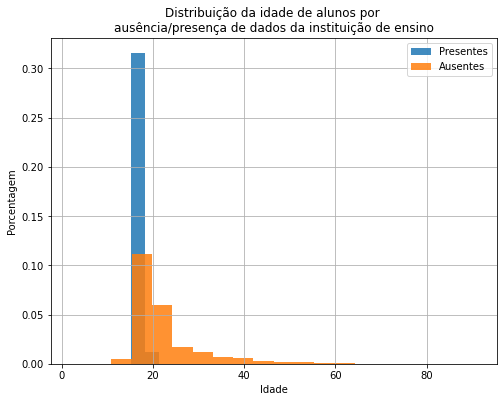

In [7]:
df['ESCOLA_FALTANTE'] = ((df.TP_ENSINO.isna()) | (df.CO_ESCOLA.isna()) | (df.NO_MUNICIPIO_ESC.isna()) | 
                         (df.SG_UF_ESC.isna()) | (df.TP_DEPENDENCIA_ADM_ESC.isna()) | (df.TP_LOCALIZACAO_ESC.isna()) | 
                         (df.TP_SIT_FUNC_ESC.isna()))
print(f'Porcentagem com algum dado da instituição de ensino ausente: {df.ESCOLA_FALTANTE.mean()*100:.2f}%')

fig = plt.figure(figsize = (8, 6))
plt.hist(df[df.ESCOLA_FALTANTE == False].NU_IDADE, bins = 20, density= True, alpha = 0.85, label = 'Presentes')
plt.hist(df[df.ESCOLA_FALTANTE == True].NU_IDADE, bins = 20, density= True, alpha = 0.85, label = 'Ausentes')
plt.title('Distribuição da idade de alunos por \nausência/presença de dados da instituição de ensino')
plt.grid()
plt.xlabel('Idade')
plt.ylabel('Porcentagem')
plt.legend()
plt.show()

Podemos notar que a distribuição das idades dos participantes apresenta diferenças entre o grupo que apresentou os dados da instituição de ensino ou não, __os participantes que apresentaram as informações são considerávelmente mais novos__. Podemos considerar que parte desses participantes que não apresentaram as informações não tivessem mais elas pelo tempo desde a idade escolar.

## Idade e gênero

Agora considerando os alunos sem notas faltantes, verifiquemos se a distribuição da nota média possui relação com a idade e o gênero.

Idade média dos participantes: 20.91
Porcentagem de participantes do sexo feminino: 59.00%
Idade média dos participantes do sexo feminino:  20.86 ± 6.96
Idade média dos participantes do sexo masculino: 20.98 ± 6.81


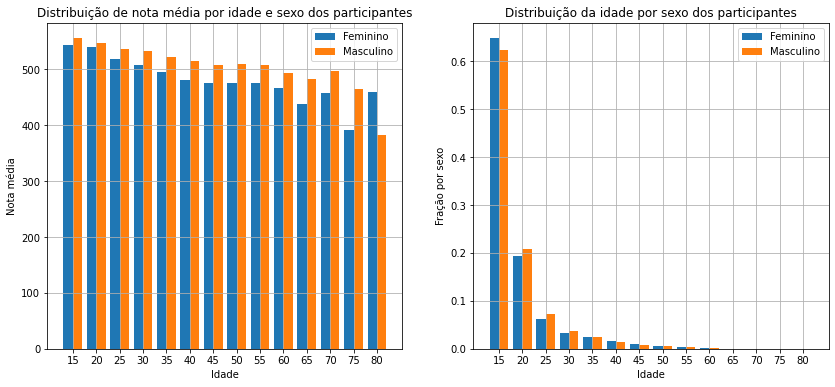

In [9]:
df['NU_NOTA'] = 0.2*(df.NU_NOTA_CH + df.NU_NOTA_CN + df.NU_NOTA_LC + df.NU_NOTA_MT + df.NU_NOTA_REDACAO)
print(f'Idade média dos participantes: {df.NU_IDADE.mean():.2f}')
fem_frac = (df.TP_SEXO == 'F').mean()
age_mean_fem = df[df.TP_SEXO == 'F'].NU_IDADE.mean()
age_mean_masc = df[df.TP_SEXO == 'M'].NU_IDADE.mean()
age_std_fem = df[df.TP_SEXO == 'F'].NU_IDADE.std()
age_std_masc = df[df.TP_SEXO == 'M'].NU_IDADE.std()

print(f'Porcentagem de participantes do sexo feminino: {fem_frac*100:.2f}%')
print(f'Idade média dos participantes do sexo feminino:  {age_mean_fem:.2f} ± {age_std_fem:.2f}')
print(f'Idade média dos participantes do sexo masculino: {age_mean_masc:.2f} ± {age_std_masc:.2f}')
age_intervals = [[i, i+5] for i in range(15,85, 5)]
age_intervals[-1][1] = 150
masc = np.zeros(shape = len(age_intervals))
masc_hist = np.zeros(shape = len(age_intervals))
fem = np.zeros(shape = len(age_intervals))
fem_hist = np.zeros(shape = len(age_intervals))
for i in range(len(age_intervals)):
    age_sup = age_intervals[i][1]
    age_inf = age_intervals[i][0]
    masc[i] = df[(df.TP_SEXO == 'M') & (df.NU_IDADE >= age_inf) & (df.NU_IDADE < age_sup)].NU_NOTA.mean()
    fem[i] = df[(df.TP_SEXO == 'F') & (df.NU_IDADE >= age_inf) & (df.NU_IDADE < age_sup)].NU_NOTA.mean()
    masc_hist[i] = df[(df.TP_SEXO == 'M') & (df.NU_IDADE >= age_inf) & (df.NU_IDADE < age_sup)].shape[0]
    fem_hist[i] = df[(df.TP_SEXO == 'F') & (df.NU_IDADE >= age_inf) & (df.NU_IDADE < age_sup)].shape[0]
fig, ax = plt.subplots(ncols = 2, figsize = (14, 6))
ax[0].bar([i[0]-1 for i in age_intervals], fem, width = 2,label = 'Feminino')
ax[0].bar([i[0]+1 for i in age_intervals], masc, width = 2,  label = 'Masculino')
ax[0].set_xticks([i[0] for i in age_intervals])
ax[0].set_title('Distribuição de nota média por idade e sexo dos participantes')
ax[0].set_xlabel('Idade')
ax[0].set_ylabel('Nota média')
ax[0].legend()
ax[0].grid()


ax[1].bar([i[0]-1 for i in age_intervals], fem_hist/fem_hist.sum(), width = 2, label = 'Feminino')
ax[1].bar([i[0]+1 for i in age_intervals], masc_hist/masc_hist.sum(), width = 2, label = 'Masculino')
ax[1].set_xticks([i[0] for i in age_intervals])
ax[1].set_title('Distribuição da idade por sexo dos participantes')
ax[1].set_xlabel('Idade')
ax[1].set_ylabel('Fração por sexo')
ax[1].legend()
ax[1].grid()
plt.show()

Notamos que existe uma __tendência de notas mais altas entre os homens entre as diferentes faixas etárias, e que a nota média decresce quando a idade do participante aumenta__, também é visível que __os participantes do sexo feminino são maioria na faixa de etária entre 15 e 20 anos, mas são minoria nas demais faixas__.

## Cor/raça

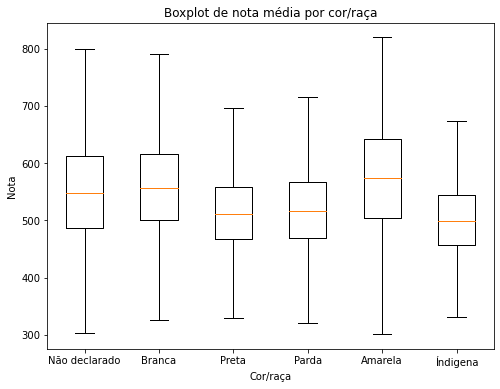

In [11]:
fig = plt.figure(figsize = (8, 6))
ethinic_lists = []
ethinic_dict = {0:'Não declarado', 1:'Branca', 2:'Preta', 3:'Parda', 4:'Amarela', 5:'Índigena'}
for i in range(6):
    ethinic_lists.append(df[(df.TP_COR_RACA == i) & (1 - df.NU_NOTA.isna())].NU_NOTA.tolist())
plt.boxplot(ethinic_lists, showfliers = False)
plt.xticks(ticks = list(range(1,7)), labels = [ethinic_dict[i] for i in range(6)])
plt.title('Boxplot de nota média por cor/raça')
plt.xlabel('Cor/raça')
plt.ylabel('Nota')
plt.show()

## Renda familiar

Utilizando da questão 6 socioeconômica, que separa os participantes de acordo com a renda familiar, podemos olhar a distribuição dos alunos de acordo com sua renda.

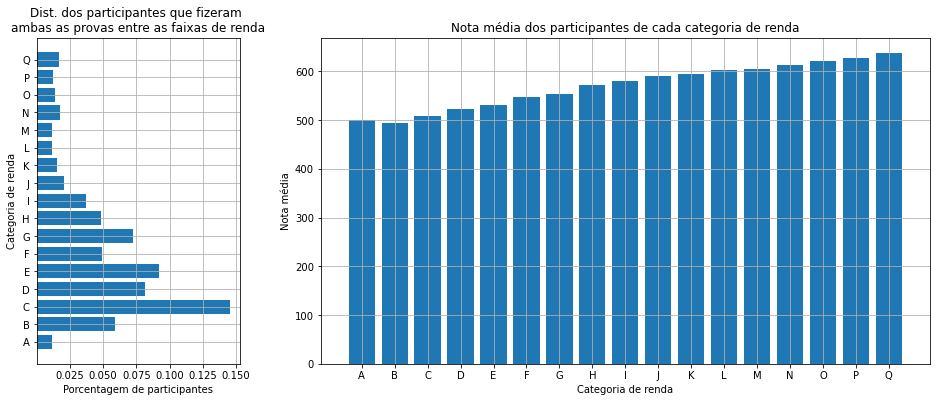

In [12]:
income_interval = {'A':[0, 0], 'B': [0, 998], 'C': [998, 1497], 'D':[1497, 1996], 'E':[1996, 2495],
                  'F':[2495, 2994], 'G': [2994, 3992], 'H':[3992, 4990], 'I':[4990, 5988], 'J':[5988, 6986],
                  'K':[6986, 7984], 'L':[7984, 8982], 'M':[8982, 9980], 'N':[9980, 11976], 'O':[11976, 14970], 
                   'P':[14970, 19960], 'Q':[19960, 100000]}
n_keys = len(list(income_interval.keys()))
fig = plt.figure(figsize = (16, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
income_fraction_presence = [[key, ((df['Q006'] == key) & (df.AUSENTE_PROVA == 0)).mean()] for key in income_interval.keys()]
ax0 = plt.subplot(gs[0])
ax0.barh(y = list(range(n_keys)), width = [x[1] for x in income_fraction_presence])
ax0.set_yticks(ticks = list(range(n_keys)))
ax0.set_yticklabels(labels = list(income_interval.keys()))
ax0.set_xticks(ticks = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15])
ax0.set_xlabel("Porcentagem de participantes")
ax0.set_ylabel("Categoria de renda")
ax0.set_title("Dist. dos participantes que fizeram \nambas as provas entre as faixas de renda")
ax0.grid()

income_mean_note = [[key, df[(df['Q006'] == key) & (df.AUSENTE_PROVA == 0)].NU_NOTA.mean()] for key in income_interval.keys()]
ax1 = plt.subplot(gs[1])
ax1.bar(x = list(range(n_keys)), height = [x[1] for x in income_mean_note])
ax1.set_xticks(ticks = list(range(n_keys)))
ax1.set_xticklabels(labels = list(income_interval.keys()))

ax1.set_title("Nota média dos participantes de cada categoria de renda")
ax1.set_xlabel("Categoria de renda")
ax1.set_ylabel("Nota média")
ax1.grid()




plt.show()

Vemos que a nota média cresce de acordo com a renda, __participantes da categoria A possuem média de 500, enquanto que participantes da categoria Q possuem média em torno de 650__.

## Atendimendo especializado

A aplicação da prova pode ser acompanhada por atendimento especializado caso o participante possua alguma necessidade especial. Inicialmente iremos olhar pela quantidade de participantes que possuem necessidades especiais e se há diferença na nota média entre os que possuem e os que não possuem.

Atendimentos especializados com média maior do que a média geral:
 DEFICIT ATENCAO
 DISLEXIA
 OUTRA DEF
 TEMPO ADICIONAL
 MESA CADEIRA SEPARADA
 COMPUTADOR
 CADEIRA ESPECIAL
 CADEIRA ACOLCHOADA
 MOBILIARIO OBESO
 LAMINA OVERLAY
 PROTETOR AURICULAR
 MEDIDOR GLICOSE
 MARCA PASSO
 MEDICAMENTOS
 SALA INDIVIDUAL
 SALA ESPECIAL
 MOBILIARIO ESPECIFICO
 MATERIAL ESPECIFICO
 NOME SOCIAL


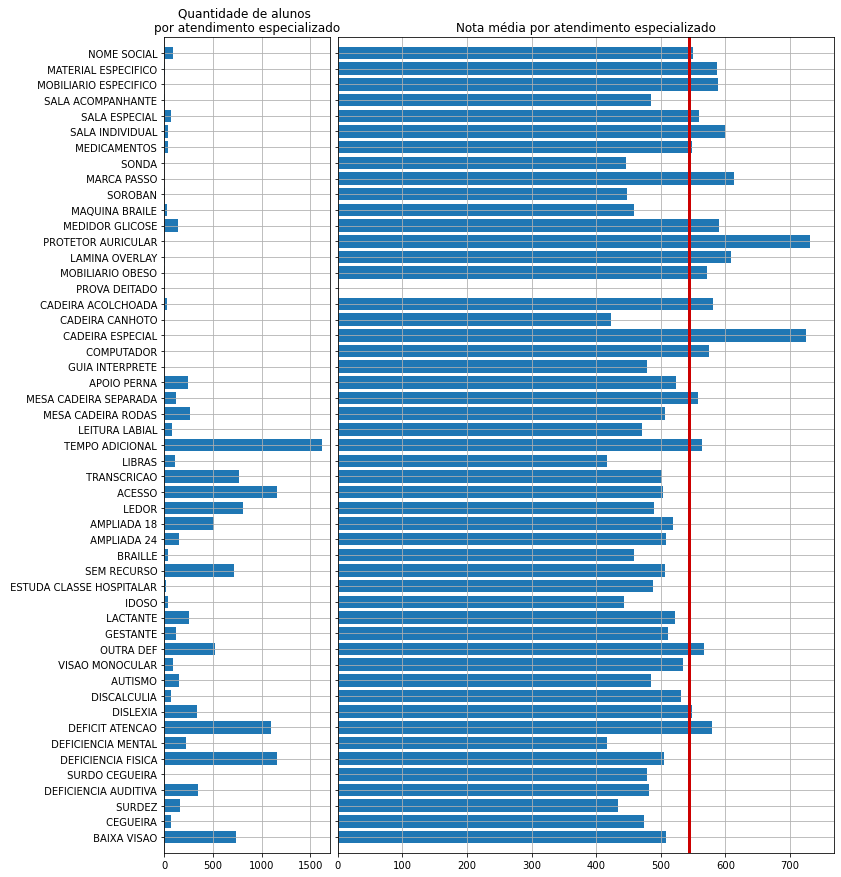

In [13]:
columns_special_need = [x for x in df.columns if x[0:2] == 'IN']
columns_special_need.remove('IN_TREINEIRO')
d_special = {}
d_special_count = {}
for col in columns_special_need:
    d_special[col] = df[df[col] == 1].NU_NOTA.mean()
    d_special_count[col] = df[df[col] == 1].shape[0]

fig = plt.figure(figsize = (12, 15))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])
gs.update(wspace=0.025, hspace=0.05)
ax = [plt.subplot(gs[0]), plt.subplot(gs[1])]
    
print("Atendimentos especializados com média maior do que a média geral:")
print("\n".join([col[2:].replace('_', ' ') for col in columns_special_need if d_special[col] > df.NU_NOTA.mean()]))

ax[0].barh(list(range(len(d_special))), [d_special_count[col] for col in columns_special_need])
ax[0].set_yticks(ticks = list(range(len(d_special))))
ax[0].set_yticklabels(labels = [col[2:].replace('_', ' ') for col in columns_special_need])
ax[0].set_title('Quantidade de alunos \npor atendimento especializado')
ax[0].set_ylim((-1, len(d_special)))
ax[0].grid()

ax[1].barh(list(range(len(d_special))), [d_special[col] for col in columns_special_need])
ax[1].plot([df.NU_NOTA.mean(), df.NU_NOTA.mean()], [-1, len(d_special)], linewidth = 3, c = "#CC0000")
ax[1].set_yticks(ticks = list(range(len(d_special))))
ax[1].set_yticklabels(labels = ['' for col in columns_special_need])
ax[1].set_title('Nota média por atendimento especializado')
ax[1].set_ylim((-1, len(d_special)))
ax[1].grid()

plt.show()